**Exercise 6.4**

MNIST with fully connected networks and grid/random search

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tabulate import tabulate
from tensorflow.keras import layers

The MNIST data base of handwritten numbers is directly available through KERAS. The following codeblocks download and preprocess the data. 

In [92]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data() # download test and train data



# split test data into validation and test data
x_valid = x_test[8000:] 
y_valid = y_test[8000:]
x_test = x_test[:8000]
y_test = y_test[:8000]

# Hint: convert integer RGB values (0-255) to float values (0-1)


In [93]:
# shows shapes and train, validation and test dataset size
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_valid.shape[0], "validation samples")
print(x_test.shape[0], "test samples")


x_train shape: (60000, 28, 28)
60000 train samples
2000 validation samples
8000 test samples


In this exercise, a fully connected neural network is used to predict the handwritten numbers. To do this, we reformat the pictures with 28x28 pixels into a vector with a length of 28x28=784.

# Normalization

Here we also normalise the input data by simply dividing by / 255

In [94]:
# reshape the image matrices to vectors
x_train = x_train.reshape(-1, 28**2).astype("float32") / 255.0
x_valid = x_valid.reshape(-1, 28**2).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28**2).astype("float32") / 255.0
# print new shape
print("x_train shape:", x_train.shape)

x_train shape: (60000, 784)


We use "onehot" encoding of the classes. This means a "zero" is encoded as `[1,0,0,0,0,0,0,0,0,0]` and a "one" as `[0,1,0,0,0,0,0,0,0,0]` etc. 
This is done because our network will have ten output nodes with the output node with the largest value being the predicted number.

In [95]:
# convert class vectors to binary class matrices (10 numbers/classes)
y_train_onehot = tf.keras.utils.to_categorical(y_train, 10)
y_valid_onehot = tf.keras.utils.to_categorical(y_valid, 10)
y_test_onehot = tf.keras.utils.to_categorical(y_test, 10)

#print(y_test_onehot[0])

In [96]:
# define model here

nb_nodes = 10
nb_layers = 1

model = tf.keras.models.Sequential()
model.add(layers.Dense(nb_nodes, activation = 'ReLU', input_shape=(784,)))

for i in range (1,nb_layers):
  model.add(layers.Dense(nb_nodes, activation = 'ReLU'))
    

model.add(layers.Dense(10, activation = 'softmax'))  # softmax actication to transform output into probabiliites

print(model.summary())

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_193 (Dense)           (None, 10)                7850      
                                                                 
 dense_194 (Dense)           (None, 10)                110       
                                                                 
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________
None


In [97]:
# create the model with specifying loss, optimizer and metric
model.compile(
    loss='categorical_crossentropy',  # the recommended loss for a classification task is 'categorical_crossentropy' (see lecture for details)
    optimizer= 'adam',
    metrics=['accuracy']) # we use accuracy to quanitfy to network performance. 

# define callbacks for training
save_best = tf.keras.callbacks.ModelCheckpoint( # to save model and model weights at some frequency
    "best_model_{}.h5".format(model.name),
    save_best_only=True, # only save the best last model
    monitor="val_accuracy", # what conditionned the saving
    save_weights_only=True, # only weight are saved
)

# Keras calculates training accuracy and loss during the training and with regularization applied,
# while the validation metrics are calculated at the end of each epoch.
# This callback calculates the training metrics the same way as for the validation
class CalculateMetrics(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}): # at the end of each epoch
        train_loss, train_acc = model.evaluate(x_train, y_train_onehot, verbose=0) # get training metrics
        logs["train_loss"] = train_loss # display train_loss
        logs["train_acc"] = train_acc # display train_acc

results = model.fit(
    x_train, y_train_onehot,
    validation_data=(x_valid, y_valid_onehot), # display validation metric and loss
    
    batch_size=32,
    epochs=10,
    callbacks=[ # 3 callbacks !
        save_best, # defined above 
        CalculateMetrics(), # defined above
        tf.keras.callbacks.CSVLogger("history_{}.csv".format(model.name)) # defined now ! # write epcohs result to a CSV file
    ]
    )

# the "dynamic" loss calculation is automaticaly (by KERAS) displayed in the console

Epoch 1/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.4848 - accuracy: 0.8626 - val_loss: 0.2133 - val_accuracy: 0.9400 - train_loss: 0.3023 - train_acc: 0.9146
Epoch 2/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.2852 - accuracy: 0.9184 - val_loss: 0.1842 - val_accuracy: 0.9455 - train_loss: 0.2599 - train_acc: 0.9270
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2591 - accuracy: 0.9260 - val_loss: 0.1732 - val_accuracy: 0.9515 - train_loss: 0.2438 - train_acc: 0.9310
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2430 - accuracy: 0.9314 - val_loss: 0.1626 - val_accuracy: 0.9500 - train_loss: 0.2272 - train_acc: 0.9363
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2318 - accuracy: 0.9346 - val_loss: 0.1618 - val_accuracy: 0.9540 - train_loss: 0.2199 - train_acc: 0.9377
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - l

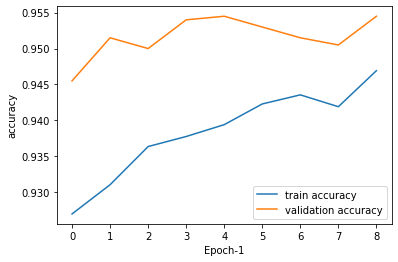

final accuracy on the test data set : 0.9269999861717224


In [98]:
# load best model
model.load_weights(f"best_model_{model.name}.h5")

# ------------------------
# ---     Plotting     ---
# ------------------------

# plot training history
history = np.genfromtxt(f"history_{model.name}.csv", delimiter=",", names=True)

# add plots below - Plot the training and validation accuracy as a function of epoch
train_acc = history["train_acc"][1:]
val_accuracy = history["val_accuracy"][1:]

plt.plot(train_acc,label="train accuracy")
plt.plot(val_accuracy,label="validation accuracy")
plt.legend()
plt.xlabel("Epoch-1")
plt.ylabel("accuracy")
plt.show()

# final accuracy on the test data set
print("final accuracy on the test data set :", model.evaluate(x_test, y_test_onehot, verbose=0, batch_size=128)[1])

Above, the training and validation accuracy as a function of epoch is plotted. In addition, the final accuracy on the test dataset is given.

In [99]:
# evaluate performance

print("Model performance :")
headers = ["", "Loss", "Accuracy", "Test error rate [%]"]

table = [ # 2nd column generates 2 column, the two output of the model (loss, and metric (accuracy)) / accuracy 
    ["Train", *model.evaluate(x_train, y_train_onehot, verbose=0, batch_size=128), (1-model.evaluate(x_train, y_train_onehot, verbose=0, batch_size=128)[1])*100 ],
    ["Validation", *model.evaluate(x_valid, y_valid_onehot, verbose=0, batch_size=128), (1-model.evaluate(x_valid, y_valid_onehot, verbose=0, batch_size=128)[1])*100 ],
    ["Test", *model.evaluate(x_test, y_test_onehot, verbose=0, batch_size=128), (1-model.evaluate(x_test, y_test_onehot, verbose=0, batch_size=128)[1])*100 ],
]

print(tabulate(table, headers=headers, tablefmt="orgtbl"))

Model performance :
|            |     Loss |   Accuracy |   Test error rate [%] |
|------------+----------+------------+-----------------------|
| Train      | 0.212911 |     0.9394 |                  6.06 |
| Validation | 0.15574  |     0.9545 |                  4.55 |
| Test       | 0.247588 |     0.927  |                  7.3  |


You can compare your own results with a variety of different models: http://yann.lecun.com/exdb/mnist/ and https://en.wikipedia.org/wiki/MNIST_database

The following codeblocks define some helper functions for plotting. You don't need to touch them

In [100]:
#@title 
def plot_image(X, ax=None):                                                                                                                                    
    """Plot an image X.                                                                                                                                        
                                                                                                                                                               
    Args:                                                                                                                                                      
        X (2D array): image, grayscale or RGB                                                                                                                  
        ax (None, optional): Description                                                                                                                       
    """                                                                                                                                                        
    if ax is None:                                                                                                                                             
        ax = plt.gca()                                                                                                                                         
                                                                                                                                                               
    if (X.ndim == 2) or (X.shape[-1] == 1):                                                                                                                    
        ax.imshow(X.astype('uint8'), origin='upper', cmap=plt.cm.Greys)                                                                                        
    else:                                                                                                                                                      
        ax.imshow(X.astype('uint8'), origin='upper')                                                                                                           
                                                                                                                                                               
    ax.set(xticks=[], yticks=[]) 

def plot_prediction(Yp, X, y, classes=None, top_n=False):                                                                                          
    """Plot an image along with all or the top_n predictions.                                                                                                  
                                                                                                                                                               
    Args:                                                                                                                                                      
        Yp (1D array): predicted probabilities for each class                                                                                                  
        X (2D array): image                                                                                                                                    
        y (integer): true class label                                                                                                                          
        classes (1D array, optional): class names                                                                                                              
        top_n (int, optional): number of top predictions to show
    """                                                                                                                                                        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3.2))                                                                                                     
    plt.subplots_adjust(left=0.02, right=0.98, bottom=0.15, top=0.98, wspace=0.02)                                                                             
    plot_image(X, ax1)                                                                                                                                         
                                                                                                                                                               
    if top_n:                                                                                                                                                  
        n = top_n                                                                                                                                              
        s = np.argsort(Yp)[-top_n:]                                                                                                                            
    else:                                                                                                                                                      
        n = len(Yp)                                                                                                                                            
        s = np.arange(n)[::-1]                                                                                                                                 
                                                                                                                                                               
    patches = ax2.barh(np.arange(n), Yp[s], align='center')                                                                                                    
    ax2.set(xlim=(0, 1), xlabel='Probability', yticks=[])                                                                                                      
                                                                                                                                                               
    for iy, patch in zip(s, patches):                                                                                                                          
        if iy == y:                                                                                                                                            
            patch.set_facecolor('C1')  # color correct patch                                                                                                   
                                                                                                                                                               
    if classes is None:                                                                                                                                        
        classes = np.arange(0, np.size(Yp))                                                                                                                    
                                                                                                                                                               
    for i in range(n):                                                                                                                                         
        ax2.text(0.05, i, classes[s][i], ha='left', va='center')                                                                                               
                                                                                                                                                               
    plt.show()

def plot_confusion(yp, y, classes=None, fname=None):                                                                                                           
    """Plot confusion matrix for given true and predicted class labels                                                                                         
                                                                                                                                                               
    Args:                                                                                                                                                      
        yp (1D array): predicted class labels                                                                                                                  
        y (1D array): true class labels                                                                                                                        
        classes (1D array): class names                                                                                                                        
        fname (str, optional): filename for saving the plot                                                                                                    
    """                                                                                                                                                        
    if classes is None:                                                                                                                                        
        n = max(max(yp), max(y)) + 1                                                                                                                           
        classes = np.arange(n)                                                                                                                                 
    else:                                                                                                                                                      
        n = len(classes)                                                                                                                                       
                                                                                                                                                               
    bins = np.linspace(-0.5, n - 0.5, n + 1)                                                                                                                   
    C = np.histogram2d(y, yp, bins=bins)[0]                                                                                                                    
    C = C / np.sum(C, axis=0) * 100                                                                                                                            
                                                                                                                                                               
    fig = plt.figure(figsize=(8, 8))                                                                                                                           
    plt.imshow(C, interpolation='nearest', vmin=0, vmax=100, cmap=plt.cm.YlGnBu)                                                                               
    plt.gca().set_aspect('equal')                                                                                                                              
    cbar = plt.colorbar(shrink=0.8)                                                                                                                            
    cbar.set_label('Frequency %')                                                                                                                              
    plt.xlabel('Prediction')                                                                                                                                   
    plt.ylabel('Truth')                                                                                                                                        
    plt.xticks(range(n), classes, rotation='vertical')                                                                                                         
    plt.yticks(range(n), classes)                                                                                                                              
    for x in range(n):                                                                                                                                         
        for y in range(n):                                                                                                                                     
            if np.isnan(C[x, y]):                                                                                                                              
                continue                                                                                                                                       
            color = 'white' if x == y else 'black'                                                                                                             
            plt.annotate('%.1f' % (C[x, y]), xy=(y, x), color=color, ha='center', va='center')                                                                 
                                                                                                                                                               
    plt.show()

In [ ]:
# plot a few examples, loop over test dataset:
# get missidentified samples
output = model.predict(x_test, batch_size=128)
labels = np.argmax(y_test_onehot, axis=1)
predictions = np.argmax(output, axis=1)
plot_confusion(predictions, labels)

for i in range(10): # loop over first 10 test samples
    plot_prediction(output[i], 
                    255 * np.reshape(x_test[i], (28, 28)), # we need to reshape the data into an image and convert back to RGB color scale by multiplying with 255
                    labels[i])
    

Using the template (very nice), we plot the confusion matrix for the test dataset, as well as few example of good and wrong predictions with the image and the probability prediction associated.

In [ ]:
# now plot a few examples that were misclassified

indices_miss = np.nonzero(predictions != labels)[0]
x_missid = x_test[indices_miss]

for i in indices_miss[:10]:
    plot_prediction(output[i], 
                    255 * np.reshape(x_test[i], (28, 28)), # we need to reshape the data into an image and convert back to RGB color scale by multiplying with 255
                    labels[i])

# or plot 32 of them in a joint plot
fig = plt.figure()
ax = fig.add_subplot(111)
plotdata = x_missid[:32]
plotdata = np.hstack(np.concatenate(np.reshape(plotdata, (4, 8, 28, 28)), axis=1))
ax.imshow(plotdata, cmap="gray")


# Experiment different network structure

Number of trial have been done with three different umber of nodes (10, 50, 128)and layers (1, 10, 50). One can first observe that when the network get too deep (50 layers) the classification accuracy becomes irrelevant, that is around 0.1, giving strong insight on the negative effect of too deep network for this problem.
When it comes to the number of nodes, too little number impact negatively prediction accuracy (down to 0.91 for 10 neurons) whereas other values (128 and 50) seems close in terms of result ranging constantly around 0.97 in accuracy.

For better configuration of the network, a grid search could be carried out.

**Grid search**

Let's search the two hyperparameters dropout and number of nodes. You can start from the template below. 



In [ ]:
nb_layers = 1
batch_size_values = np.array([32, 64, 128])
n_neurons_values = np.array([50, 128, 300])
results_gridsearch = np.zeros((len(batch_size_values), len(n_neurons_values), 2))
for iDrop, drop in enumerate(batch_size_values):
  for iN, n_neurons in enumerate(n_neurons_values):

    model = tf.keras.models.Sequential()

    model.add(layers.Dense(n_neurons_values[iN], activation = 'ReLU', input_shape=(784,)))
    for i in range (1,nb_layers):
      model.add(layers.Dense(n_neurons_values[iN], activation = 'ReLU'))    
    model.add(layers.Dense(10, activation = 'softmax'))  # softmax actication to transform output into probabiliites

    model.compile(
        loss='categorical_crossentropy',  # the recommended loss for a classification task is 'categorical_crossentropy' (see lecture for details)
        optimizer='adam',
        metrics=['accuracy']) # we use accuracy to quanitfy to network performance. 

    results = model.fit(
        x_train, y_train_onehot,
        validation_data=(x_valid, y_valid_onehot),
        batch_size=batch_size_values[iDrop],
        epochs=10,
        verbose=0
        )
    t = model.evaluate(x_test, y_test_onehot, verbose=0, batch_size=128)
    results_gridsearch[iDrop, iN] = t
    print(f"batch size = {drop:.2f}, {n_neurons} neurons -> accuracy {results_gridsearch[iDrop, iN][1]:.3f}, error rate = {100*(1-results_gridsearch[iDrop, iN][1]):.1f}%")


After a grid search on two parameters, namely the batch size and the number of neurons, according to the result on the test dataset, the best highest accuracy was found to be equal to 0.980, which was found for:
batch size = 32, and 300 neurons !

**Random seach**

Now lets implement a random search. A random search allows us to scan more hyperparameters at once without more computing time. You can start from the template below. 




In [110]:
N = 20 # number of trials 
search = {
'batch_size': np.random.choice([16, 32, 64, 128, 256], N),
'num_neurons': np.random.choice([8, 32, 128, 256, 512], N),
'learn_rate': np.random.choice([0.0001, 0.001, 0.01, 0.1, 1],N),
'activation': np.random.choice(['relu', 'elu', 'sigmoid', 'tanh'], N),
'dropout': np.random.choice([0.0, 0.1, 0.2, 0.3, 0.5, 0.6], N),
'val_acc': np.zeros(N)
}

for i in range(N):
  # you can access the current value of the hyperparameter with `search['batch_size'][i]`
  model = tf.keras.models.Sequential([
                      tf.keras.layers.Dense(search['num_neurons'][i], activation = search['activation'][i], input_shape=(784,)),
                      #tf.keras.layers.Dropout(search['dropout'][i]),#, activation = search['activation'][i], input_shape=(784,)),
                      tf.keras.layers.Dropout(search['dropout'][i]),
                      tf.keras.layers.Dense(10, activation='softmax')])
  
  optimizer = tf.keras.optimizers.Adam(learning_rate=search['learn_rate'][i])
  model.compile(loss='categorical_crossentropy',
  optimizer=optimizer,
  metrics=['accuracy'])

  #print(model.summary())

  results = model.fit(
        x_train, y_train_onehot,
        validation_data=(x_valid, y_valid_onehot),
        batch_size=search['batch_size'][i],
        epochs=10,
        verbose=0
      )
  
  
  
  search['val_acc'][i] = model.evaluate(x_test, y_test_onehot, verbose=0, batch_size=128)[1]
  print(f"iteration {i}:")
  for key in search:
    print(f"\t{key}: {search[key][i]}")
  print(f"\t-> accuracy {search['val_acc'][i]:.3f}, error rate = {100*(1-search['val_acc'][i]):.1f}%")


iteration 0:
	batch_size: 64
	num_neurons: 128
	learn_rate: 0.001
	activation: relu
	dropout: 0.5
	val_acc: 0.9752500057220459
	-> accuracy 0.975, error rate = 2.5%
iteration 1:
	batch_size: 16
	num_neurons: 512
	learn_rate: 0.0001
	activation: elu
	dropout: 0.3
	val_acc: 0.9642500281333923
	-> accuracy 0.964, error rate = 3.6%
iteration 2:
	batch_size: 32
	num_neurons: 128
	learn_rate: 1.0
	activation: tanh
	dropout: 0.1
	val_acc: 0.6741250157356262
	-> accuracy 0.674, error rate = 32.6%
iteration 3:
	batch_size: 16
	num_neurons: 512
	learn_rate: 0.0001
	activation: tanh
	dropout: 0.3
	val_acc: 0.9610000252723694
	-> accuracy 0.961, error rate = 3.9%
iteration 4:
	batch_size: 256
	num_neurons: 8
	learn_rate: 0.001
	activation: sigmoid
	dropout: 0.3
	val_acc: 0.8709999918937683
	-> accuracy 0.871, error rate = 12.9%
iteration 5:
	batch_size: 128
	num_neurons: 128
	learn_rate: 0.01
	activation: relu
	dropout: 0.1
	val_acc: 0.9668750166893005
	-> accuracy 0.967, error rate = 3.3%
iterati

After a random search on 5 parameters, with 20 trials, the best highest accuracy was found to be equal to 0.975, which was found for: 
batch size = 64, 128 neurons, learning rate = 0.001, dropout = 0.5 and relu activation function !

One can observe that the best model found with random search has an accuracy very close to the one found with grid search, but slightly worse (0.975 < 0.980)!